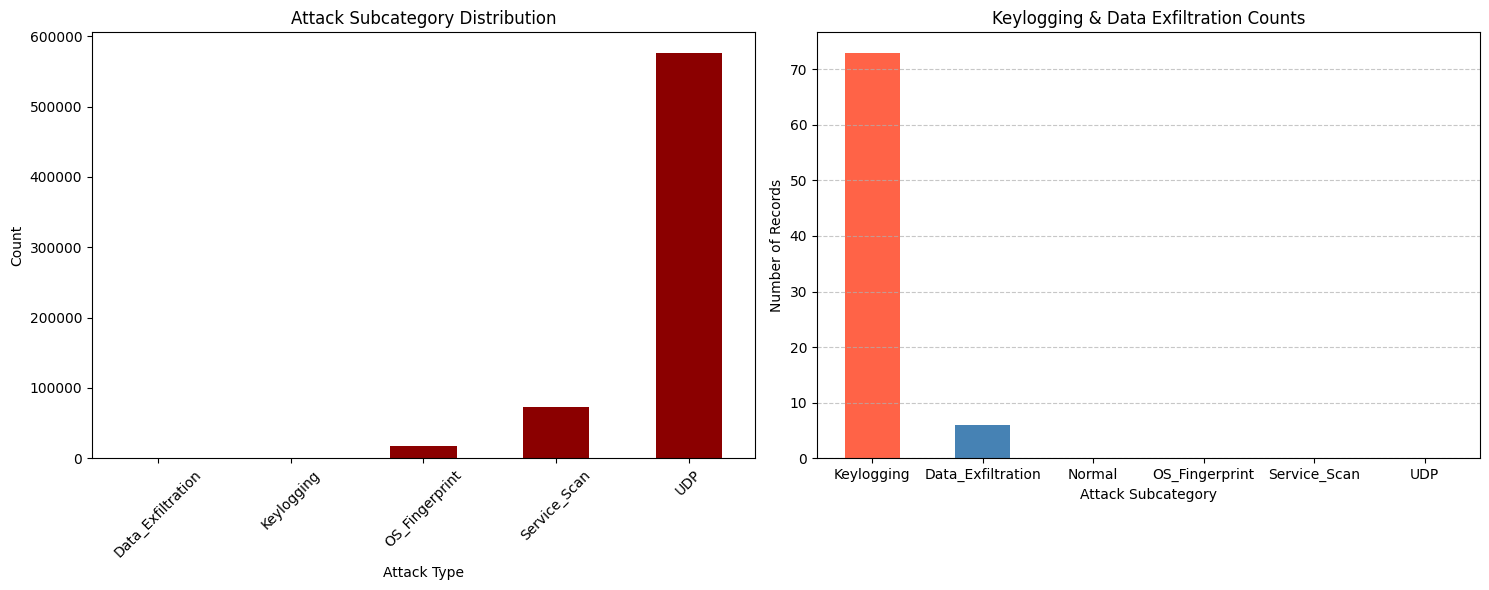

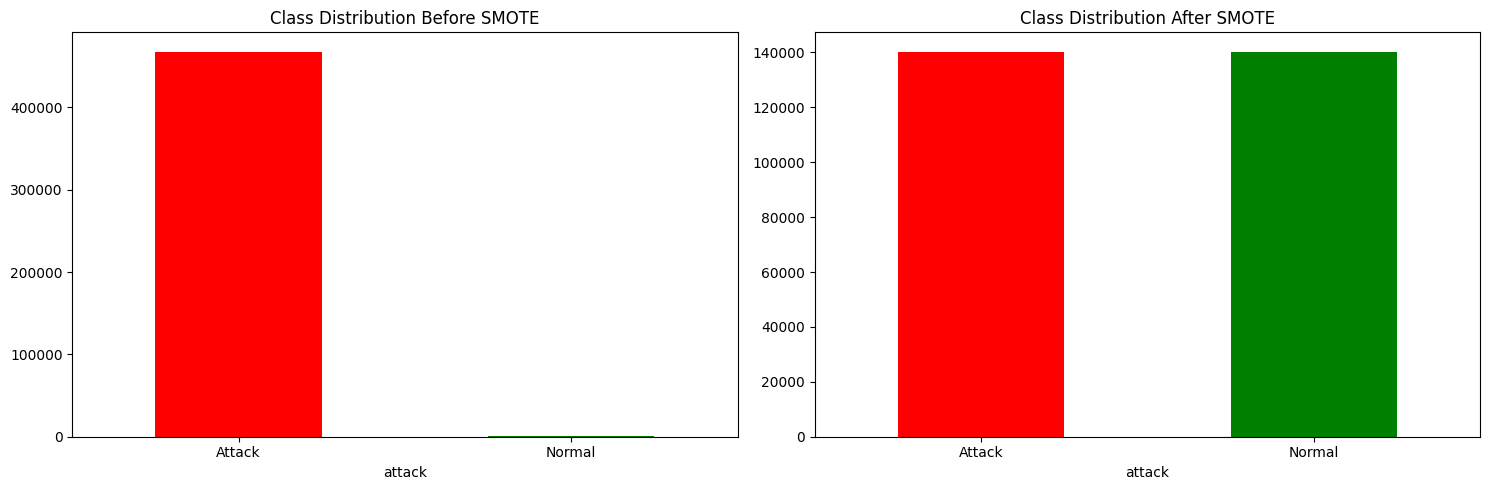

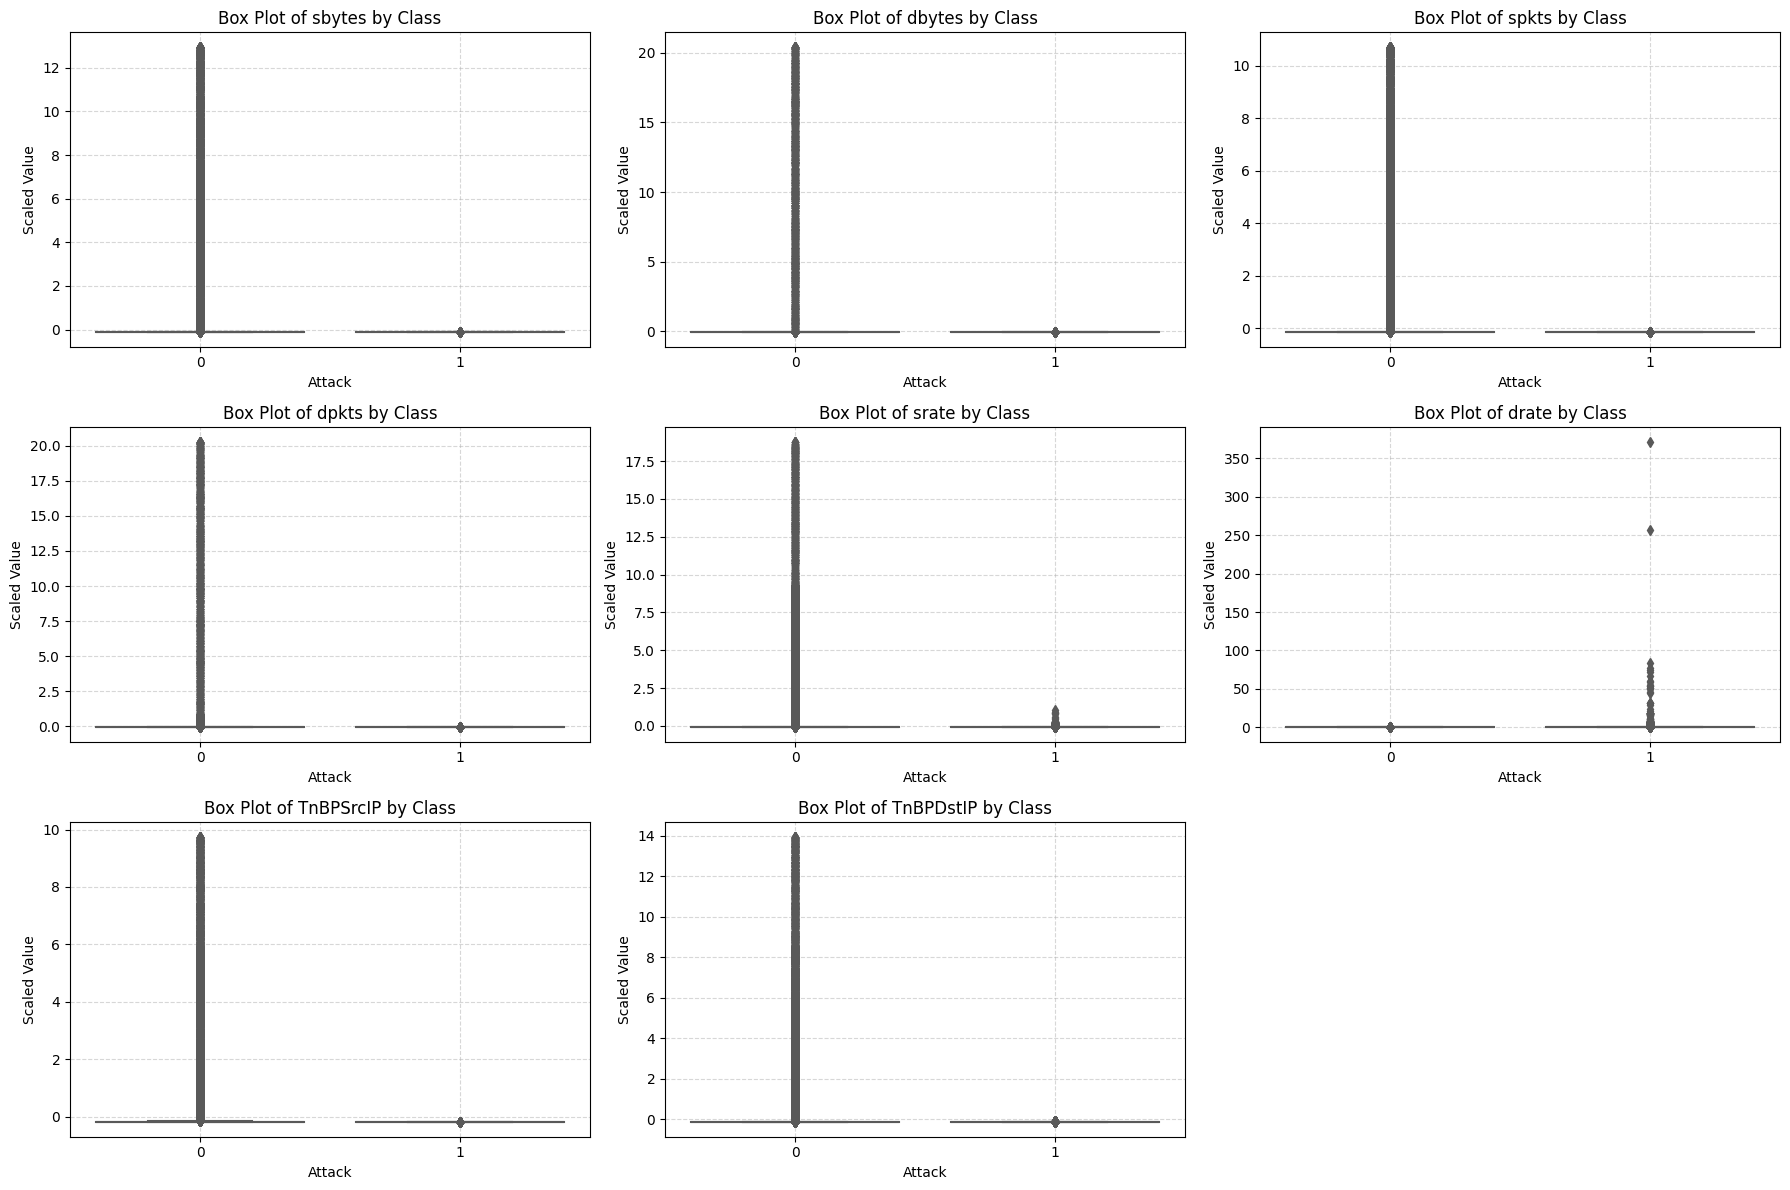

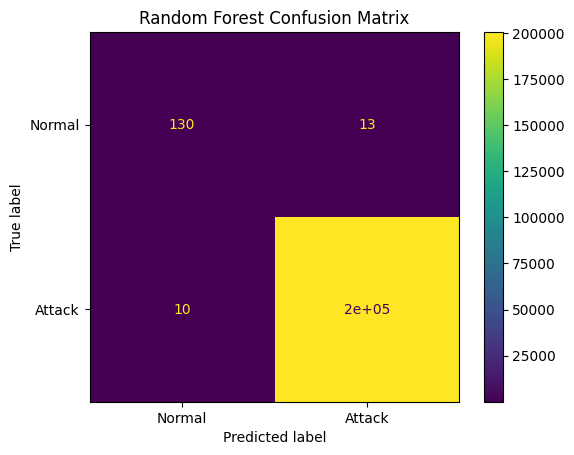

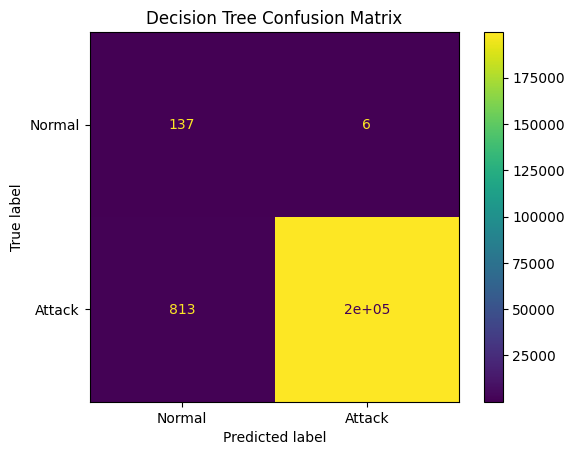

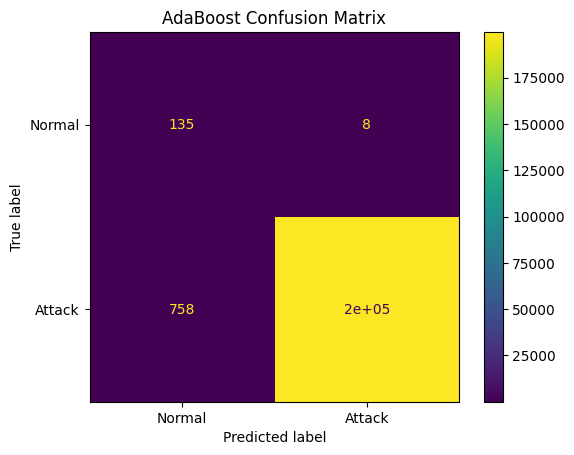

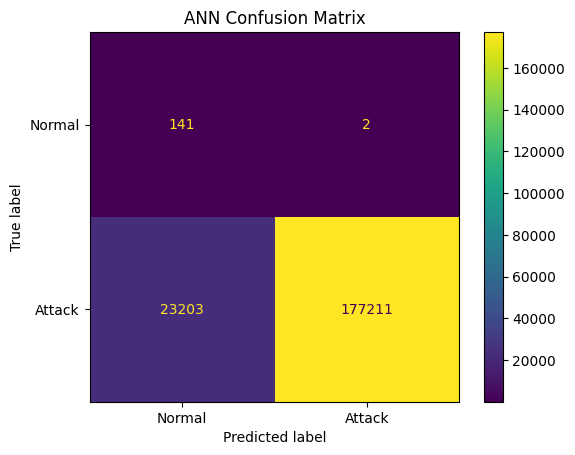

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1744725953.615772     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


6268/6268 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


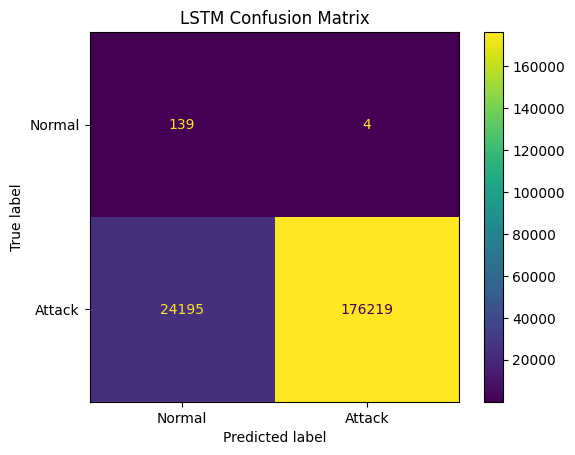

I0000 00:00:1744726052.132248     104 service.cc:148] XLA service 0x7d2388601400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744726052.132989     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744726052.618153     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6268/6268 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


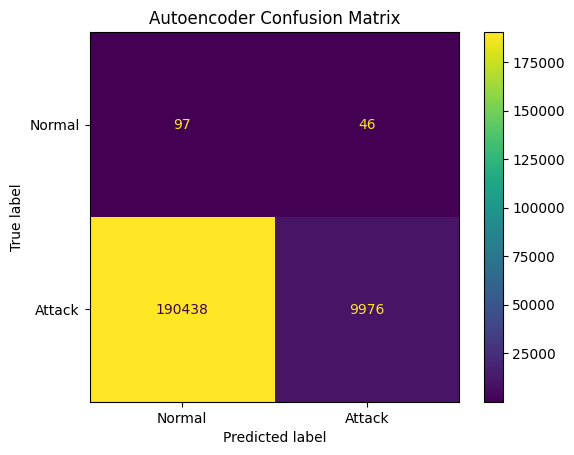

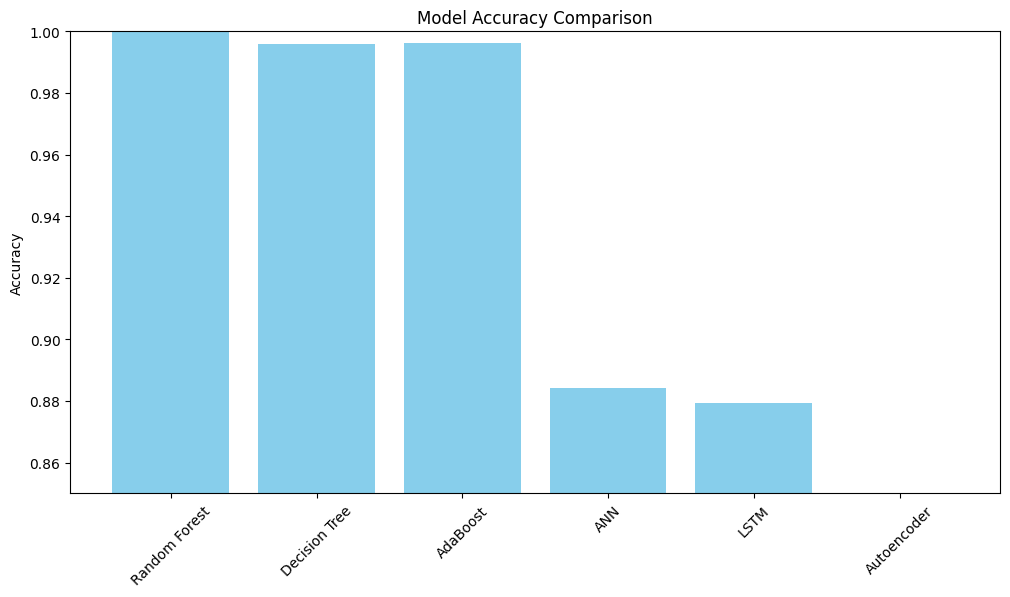

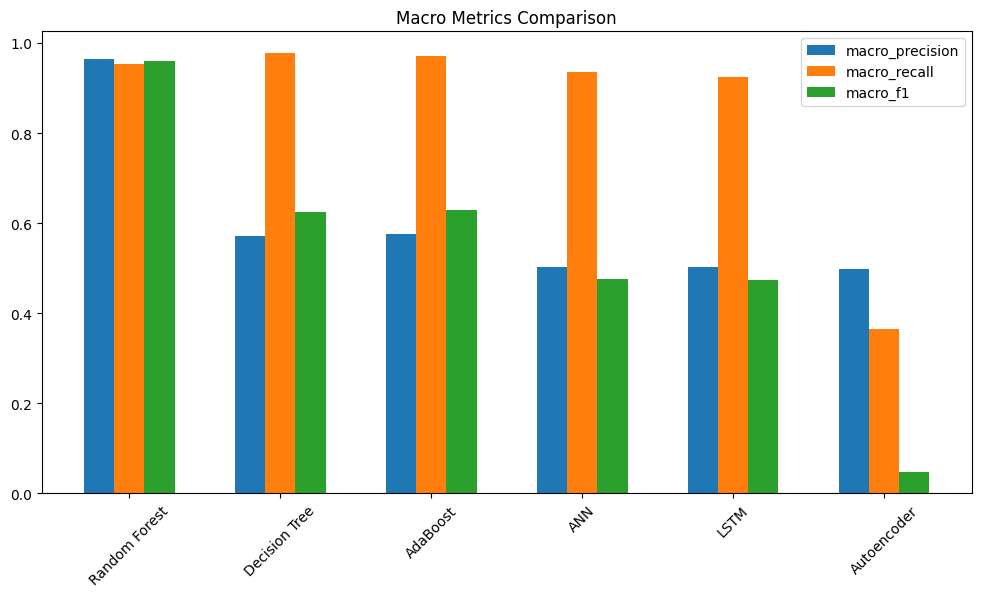

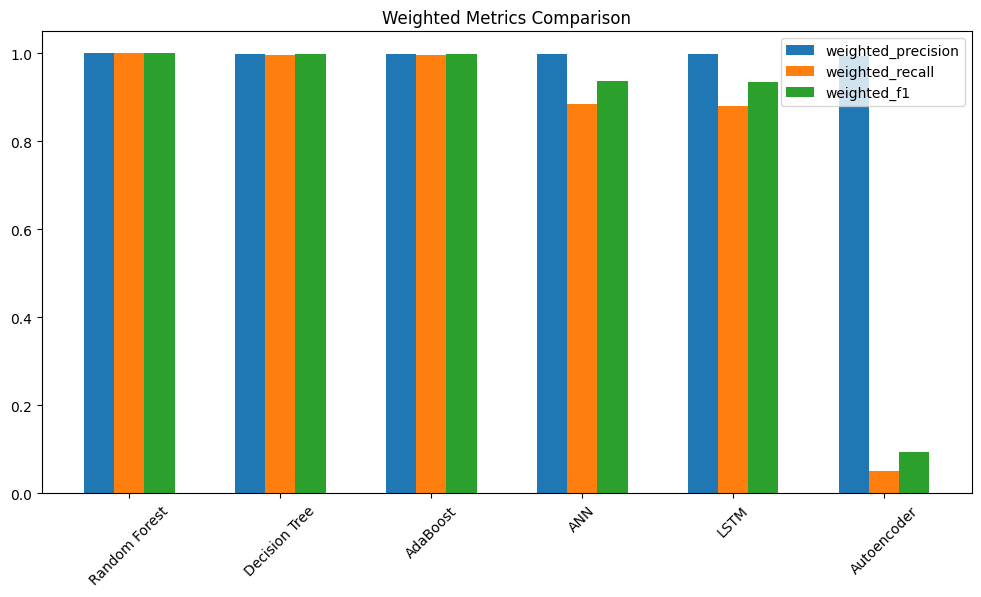


=== Classifier Performance Summary ===

🔹 Random Forest
   - Accuracy                 : 0.9999
   - Macro Precision          : 0.9643
   - Macro Recall             : 0.9545
   - Macro F1                 : 0.9593
   - Weighted Precision       : 0.9999
   - Weighted Recall          : 0.9999
   - Weighted F1              : 0.9999
--------------------------------------------------
🔹 Decision Tree
   - Accuracy                 : 0.9959
   - Macro Precision          : 0.5721
   - Macro Recall             : 0.9770
   - Macro F1                 : 0.6243
   - Weighted Precision       : 0.9994
   - Weighted Recall          : 0.9959
   - Weighted F1              : 0.9974
--------------------------------------------------
🔹 AdaBoost
   - Accuracy                 : 0.9962
   - Macro Precision          : 0.5756
   - Macro Recall             : 0.9701
   - Macro F1                 : 0.6294
   - Weighted Precision       : 0.9994
   - Weighted Recall          : 0.9962
   - Weighted F1              : 0.

In [4]:
# Optimized IoT Anomaly Detection Pipeline (Minimized Runtime)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_fscore_support)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.gridspec as gridspec

# 1. Load & Prepare Dataset
df = pd.read_csv("/kaggle/input/bot-iot-4ads/UNSW_2018_IoT_Botnet_Full5pc_4.csv", low_memory=False,
                 dtype={'attack': 'category', 'subcategory': 'category'})
df['attack'] = pd.to_numeric(df['attack'], errors='coerce').fillna(0).astype(int)
df = df[df['attack'].isin([0,1])]
attack_subcategories = ['Data_Exfiltration', 'Keylogging', 'OS_Fingerprint', 'Service_Scan', 'UDP']
df = df[(df['subcategory'].isin(attack_subcategories)) | (df['attack'] == 0)]

le = LabelEncoder()
for col in ['proto', 'state', 'flgs']:
    df[col] = le.fit_transform(df[col].astype(str))

# Trimmed feature set for speed
selected_features = [
    'sbytes', 'dbytes', 'spkts', 'dpkts', 'srate', 'drate',
    'TnBPSrcIP', 'TnBPDstIP'
]
for col in selected_features:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

X = df[selected_features]
y = df['attack']

# 2. Subcategory Distribution
# Combined Subcategory Distribution Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Main attack subcategory distribution
df[df['attack'] == 1]['subcategory'].value_counts()[attack_subcategories].plot(
    kind='bar', color='darkred', ax=ax1)
ax1.set_title('Attack Subcategory Distribution')
ax1.set_xlabel('Attack Type')
ax1.set_ylabel('Count')
ax1.set_xticklabels(attack_subcategories, rotation=45)

# Histogram for Keylogging & Data Exfiltration
filtered_df = df[(df['attack'] == 1) & (df['subcategory'].isin(['Keylogging', 'Data_Exfiltration']))]
attack_counts = filtered_df['subcategory'].value_counts()
attack_counts.plot(kind='bar', color=['tomato', 'steelblue'], ax=ax2)
ax2.set_title('Keylogging & Data Exfiltration Counts')
ax2.set_xlabel('Attack Subcategory')
ax2.set_ylabel('Number of Records')
ax2.set_xticklabels(attack_counts.index, rotation=0)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 3. Class Distribution Before/After SMOTE (Swapped names/colors)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
y_train.value_counts().plot(kind='bar', ax=ax1, title='Class Distribution Before SMOTE', color=['red', 'green'])
ax1.set_xticklabels(['Attack', 'Normal'], rotation=0)

# Reduce data for faster SMOTE
X_small, _, y_small, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=0.7, random_state=42)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_small, y_small)

pd.Series(y_res).value_counts().plot(kind='bar', ax=ax2, title='Class Distribution After SMOTE', color=['red', 'green'])
ax2.set_xticklabels(['Attack', 'Normal'], rotation=0)
plt.tight_layout()
plt.show()

# 4. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test.replace([np.inf, -np.inf], np.nan).fillna(0))

# Box-plot
boxplot_df = pd.DataFrame(X_train_scaled, columns=selected_features)
boxplot_df['attack'] = y_res.reset_index(drop=True)
num_features = len(selected_features)
cols = 3
rows = (num_features + cols - 1) // cols
plt.figure(figsize=(18, rows * 4))
gs = gridspec.GridSpec(rows, cols)
for i, feature in enumerate(selected_features):
    ax = plt.subplot(gs[i])
    sns.boxplot(data=boxplot_df, x='attack', y=feature, palette='Set2', ax=ax)
    ax.set_title(f'Box Plot of {feature} by Class')
    ax.set_xlabel('Attack')
    ax.set_ylabel('Scaled Value')
    ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Define Classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'ANN': MLPClassifier(hidden_layer_sizes=(25,30), max_iter=300)
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_res)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    mp, mr, mf1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    wp, wr, wf1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    results[name] = {'accuracy': acc, 'macro_precision': mp, 'macro_recall': mr, 'macro_f1': mf1,
                     'weighted_precision': wp, 'weighted_recall': wr, 'weighted_f1': wf1}
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Normal','Attack']).plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()

# 6. LSTM Model (Reduced Epochs)
X_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model_lstm = Sequential([
    LSTM(64, input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_lstm, y_res, epochs=5, batch_size=64, verbose=0)
y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_lstm)
mp, mr, mf1, _ = precision_recall_fscore_support(y_test, y_pred_lstm, average='macro')
wp, wr, wf1, _ = precision_recall_fscore_support(y_test, y_pred_lstm, average='weighted')
results['LSTM'] = {'accuracy': acc, 'macro_precision': mp, 'macro_recall': mr, 'macro_f1': mf1,
                   'weighted_precision': wp, 'weighted_recall': wr, 'weighted_f1': wf1}
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lstm), display_labels=['Normal','Attack']).plot()
plt.title('LSTM Confusion Matrix')
plt.show()

# 7. Autoencoder (Reduced Epochs)
X_auto = X_train_scaled[y_res == 0]
input_dim = X_auto.shape[1]
auto_input = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(auto_input)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(auto_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_auto, X_auto, epochs=5, batch_size=64, verbose=0)

recon = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - recon, 2), axis=1)
thresh = np.percentile(mse, 95)
y_pred_ae = (mse > thresh).astype(int)

acc = accuracy_score(y_test, y_pred_ae)
mp, mr, mf1, _ = precision_recall_fscore_support(y_test, y_pred_ae, average='macro')
wp, wr, wf1, _ = precision_recall_fscore_support(y_test, y_pred_ae, average='weighted')
results['Autoencoder'] = {'accuracy': acc, 'macro_precision': mp, 'macro_recall': mr, 'macro_f1': mf1,
                          'weighted_precision': wp, 'weighted_recall': wr, 'weighted_f1': wf1}
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_ae), display_labels=['Normal','Attack']).plot()
plt.title('Autoencoder Confusion Matrix')
plt.show()

# 8. Visual Comparisons
plt.figure(figsize=(12,6))
plt.bar(results.keys(), [results[k]['accuracy'] for k in results], color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.85, 1.0)
plt.show()

# Macro Metrics
macro_metrics = ['macro_precision', 'macro_recall', 'macro_f1']
x = np.arange(len(results))
width = 0.2
plt.figure(figsize=(12,6))
for i, metric in enumerate(macro_metrics):
    plt.bar(x + i*width, [results[k][metric] for k in results], width, label=metric)
plt.xticks(x + width, results.keys(), rotation=45)
plt.title('Macro Metrics Comparison')
plt.legend()
plt.show()

# Weighted Metrics
weighted_metrics = ['weighted_precision', 'weighted_recall', 'weighted_f1']
plt.figure(figsize=(12,6))
for i, metric in enumerate(weighted_metrics):
    plt.bar(x + i*width, [results[k][metric] for k in results], width, label=metric)
plt.xticks(x + width, results.keys(), rotation=45)
plt.title('Weighted Metrics Comparison')
plt.legend()
plt.show()

# 9. Summary
print("\n=== Classifier Performance Summary ===\n")
for model, stats in results.items():
    print(f"🔹 {model}")
    for k, v in stats.items():
        print(f"   - {k.replace('_',' ').title():25}: {v:.4f}")
    print("-" * 50)


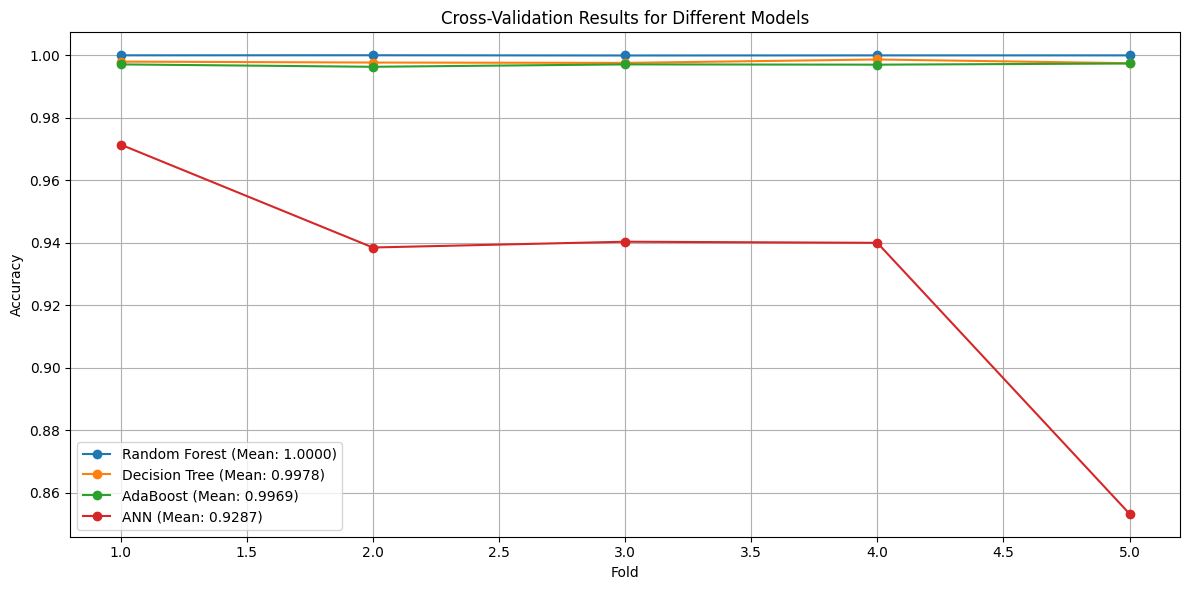

In [6]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Cross-validation for all models
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'ANN': MLPClassifier(hidden_layer_sizes=(25,30), max_iter=300)
}

# Store cross-validation results
cv_results = {}
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_scaled, y_res, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores

# LSTM and Autoencoder models are not directly compatible with cross_val_score 
# because they require reshaping of data for LSTM and reconstruction for Autoencoder.
# We can manually split and evaluate them during training.

# Plot the cross-validation results
plt.figure(figsize=(12, 6))

for name, scores in cv_results.items():
    plt.plot(range(1, 6), scores, marker='o', label=f'{name} (Mean: {np.mean(scores):.4f})')

plt.title('Cross-Validation Results for Different Models')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()